In [1]:
import emoji
import locale
import sqlite3
import numpy as np
import pandas as pd
import concurrent.futures
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from sklearn.model_selection import train_test_split
from multiprocessing_scripts import count_corresponding_reviews

### Utilities

In [2]:
def load_from_database(
        db: str,
        table: str,
        columns: str,
):
    connection = sqlite3.connect('../database/' + db + '.db')
    df = pd.read_sql_query(
        str('SELECT ' + columns + ' FROM ' + table), con=connection
    )
    connection.close()
    return df


def save_to_database(
        db: str,
        table: str,
        df: pd.DataFrame
):
    connection = sqlite3.connect('../database/' + db + '.db')
    try:
        df.to_sql(name=table, con=connection, if_exists='replace')
    except Exception as e:
        raise e
    print('DataFrame has been saved successfully to: ' + db)

In [3]:
plt.rcParams['font.size'] = 13
plt.rcParams['font.family'] = 'Palatino'
fig_path = r'/Users/leonbecker/Library/CloudStorage/OneDrive-UniversitätWürzburg/Universität Würzburg/Master Information-Systems/Thesis/LaTex/graphics/'
plt.rcParams['path.simplify'] = True
locale.setlocale(locale.LC_NUMERIC, "de_DE")
plt.rcParams['axes.formatter.use_locale'] = True

In [48]:
wine_type_ids = {
    1: 'Rotwein',
    2: 'Weißwein',
    3: 'Schaumwein',
    4: 'Roséwein',
    24: 'Likörwein',
    7: 'Dessertwein'
}

In [ ]:
con_wine = sqlite3.connect('../database/wine_distinct.db')
df_wine = pd.read_sql_query("SELECT * from wine_distinct", con_wine)
df_wine.head()

In [ ]:
for index in df_wine.index:
    df_wine.at[index, 'type_name'] = wine_type_ids[df_wine.loc[index, 'type_id']]

In [ ]:
ax = df_wine.country.value_counts().head(n=10).plot(
    kind='bar',
    color='black',
    zorder=3
)
plt.grid(zorder=0, axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig(fig_path + 'top_10_producer_countries.pdf')

In [ ]:
ax = df_wine.type_name.value_counts().plot(
    kind='bar',
    color='black',
    zorder=3
)
plt.grid(zorder=0, axis='y')
plt.xticks(rotation=0)
plt.tight_layout()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig(fig_path + 'wine_type_distribution.pdf')

In [ ]:
ax = df_wine.average_rating.plot(
    kind='box'
)
plt.grid(axis='y')
plt.tight_layout()
plt.xticks(rotation=0)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticks([])
plt.savefig(fig_path + 'average_rating.pdf')

In [ ]:
ax = df_wine.boxplot(by='type_name', column='average_rating', rot=45)
ax.set_title('')
plt.suptitle('')
ax.set_xlabel('')
plt.tight_layout()
plt.xticks(rotation=0)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# plt.savefig(fig_path + 'average_rating_by_wine.pdf')

In [ ]:
top_10_countries = df_wine.country.value_counts().head(n=10).index

In [ ]:
plt.grid(zorder=0)
ax = sb.violinplot(
    data=df_wine[df_wine.country.isin(top_10_countries)],
    y='average_rating',
    x='country',
    #palette=['w','w','w','w', 'w','w','w','w', 'w', 'w'],
    zorder=3
)
# plt.grid(axis='y')
plt.xticks(rotation=45)
plt.ylabel(None)
plt.xlabel(None)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tight_layout()
plt.savefig(fig_path + 'top_10_ratings_for_countries.pdf')

# Reviews

In [3]:
con_rev = sqlite3.connect('../database/review.db')
df_rev = pd.read_sql_query("SELECT * from review", con_rev)
df_rev.head()

,index,id,wine_id,rating,note,created_at,likes_count,comments_count,scan_image_path,user_id,note_length,len_code
0,0,66,1154225,3.5,notevole differenza tra naso e palato. con spi...,1969-12-31T23:00:01.000Z,1.0,0.0,images.vivino.com/labels/01dls5mm5nr12.jpg,4683161,18,it
1,1,2996,1652,5.0,toskaner auf absoluten top-niveau. einer der b...,2011-04-17T19:53:55.000Z,1.0,2.0,images.vivino.com/thumbs/LtqnB-H2QFmN6ixL3FQcd...,24294,18,de
2,2,3975,1101258,4.0,excellent full bodied wine,2011-07-19T21:21:22.000Z,2.0,1.0,images.vivino.com/labels/1309631550_2382.jpg,32547,4,en
3,3,4202,76378,5.0,the real price at phillipson is around 1299 dk...,2011-08-06T20:52:53.000Z,0.0,1.0,images.vivino.com/labels/1311959128_1819.jpg,48500,39,en
4,4,4261,1231210,5.0,"clean, crisp and full of nuance and elegance, ...",2011-08-11T08:06:39.000Z,3.0,1.0,images.vivino.com/labels/1312622458_6592.jpg,53601,17,en


In [4]:
df_rev['created_at'] = pd.to_datetime(df_rev.created_at)
df_rev = df_rev[1:]

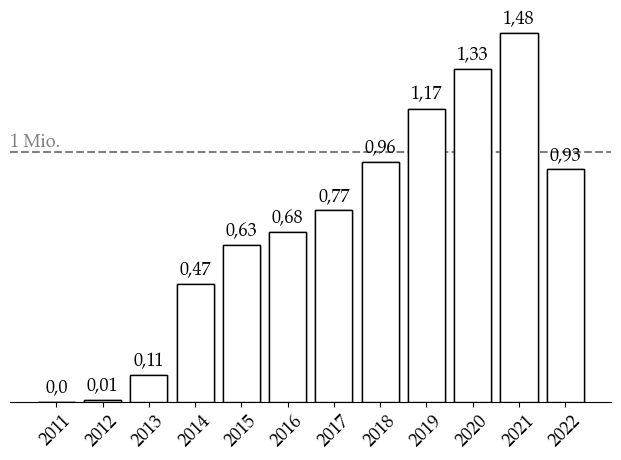

In [106]:
year_count = df_rev.groupby(df_rev.created_at.dt.year).count()
fig, ax = plt.subplots()
ax.axhline(y=1000000, linestyle='--', color='grey', label='1 Mio.')
plt.annotate(xy=(2010, 1020000), text='1 Mio.', color='grey')
ax.bar(
    x=df_rev.groupby(df_rev.created_at.dt.year).count().index,
    height=df_rev.groupby(df_rev.created_at.dt.year).count().created_at,
    edgecolor='black',
    color='white',
    zorder=3
)
ax.set_xticks(list(df_rev.groupby(df_rev.created_at.dt.year).count().index))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_yticks([])
plt.xticks(rotation=45)
container = ax.containers[0]
bars = ax.bar(year_count.index.to_list(),
              [item for sublist in df_rev.groupby(df_rev.created_at.dt.year).count().values.tolist() for item in
               sublist],
              edgecolor='black', color='white')
ax.bar_label(container,
             labels=[str.replace(str(np.round(x / 1000000, decimals=2)), '.', ',') for x in container.datavalues],
             padding=3)
plt.tight_layout()
fig.savefig(fig_path + 'yearly_reviews.pdf')

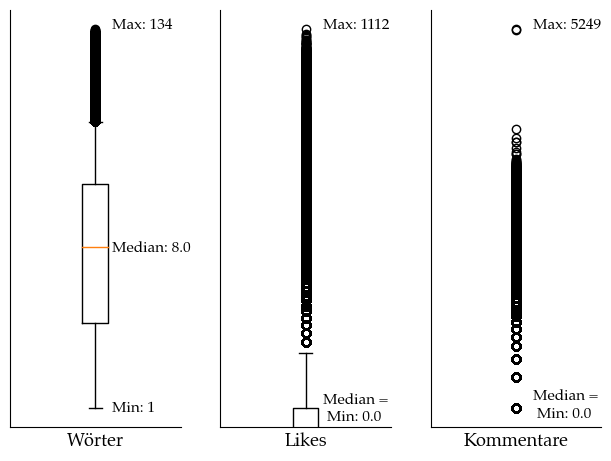

In [61]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.boxplot(
    df_rev.note_length,
    positions=[0.8]
)
ax2.boxplot(
    df_rev.likes_count,
    positions=[0.8]
)
ax3.boxplot(
    df_rev.comments_count,
    positions=[0.8]
)

ax1.set_yscale('log')
ax2.set_yscale('log')
ax3.set_yscale('log')

ax1.annotate('Max: ' + str(int(df_rev.note_length.max())), (0.9, df_rev.note_length.max()), fontsize=11)
ax1.annotate('Min: ' + str(df_rev.note_length.min()), (0.9, df_rev.note_length.min() - 0.05), fontsize=11)
ax1.annotate('Median: ' + str(df_rev.note_length.median()), (0.9, df_rev.note_length.median() - 0.5), fontsize=11)

ax2.annotate('Max: ' + str(int(df_rev.likes_count.max())), (0.9, df_rev.likes_count.max()), fontsize=11)
ax2.annotate('Median =\n Min: ' + str(df_rev.likes_count.min()), (0.9, df_rev.likes_count.min() + 1.6), fontsize=11)

ax3.annotate('Max: ' + str(int(df_rev.comments_count.max())), (0.9, df_rev.comments_count.max()), fontsize=11)
ax3.annotate('Median =\n Min: ' + str(df_rev.likes_count.min()), (0.9, df_rev.likes_count.min() + 0.8), fontsize=11)

ax1.tick_params(axis=u'both', which=u'both', length=0, labelbottom=False)
ax2.tick_params(axis=u'both', which=u'both', length=0, labelbottom=False)
ax3.tick_params(axis=u'both', which=u'both', length=0, labelbottom=False)

ax1.set_yticklabels([])
ax2.set_yticklabels([])
ax3.set_yticklabels([])

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)

ax1.set_xlabel('Wörter')
ax2.set_xlabel('Likes')
ax3.set_xlabel('Kommentare')

fig.tight_layout()
fig.savefig(fig_path + 'stats_reviews.png', dpi=300)

In [10]:
len(df_rev[df_rev.comments_count == 0]) / len(df_rev)

0.8932806500428416

In [ ]:
ax = df_rev.groupby([pd.to_datetime(df_rev.created_at).dt.date.drop(0)]).count()['index'].cumsum().plot()

In [ ]:
# convert date column to datetime and subtract one week
df_rev['created_at'] = pd.to_datetime(df_rev['created_at']) - pd.to_timedelta(7, unit='d')

# calculate sum of values, grouped by week
ax = df_rev.groupby([pd.Grouper(key='created_at', freq='W')]).count()['index'].cumsum().plot()

In [ ]:
ax = df_rev.groupby([pd.Grouper(key='created_at', freq='W')])['index'].count().cumsum().plot()

In [ ]:
df_rev.groupby([pd.to_datetime(df_rev.created_at).dt.date.drop(0)])

In [ ]:
print(ax)

In [ ]:
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('')
ax.get_figure().tight_layout()
ax.get_figure().savefig(fig_path + '/cumsum_reviews_month.pdf')

In [ ]:
pd.to_datetime(df_rev.created_at).dt.date.drop(0, inplace=True)

In [ ]:
data_var = df_rev.len_code.value_counts().head(n=10)
data_var.index = ['Englisch', 'Portugiesisch', 'Italienisch', 'Spanisch', 'Russisch',
                  'Deutsch', 'Französisch', 'Niederländisch', 'Japanisch', 'Dänisch']
data_var

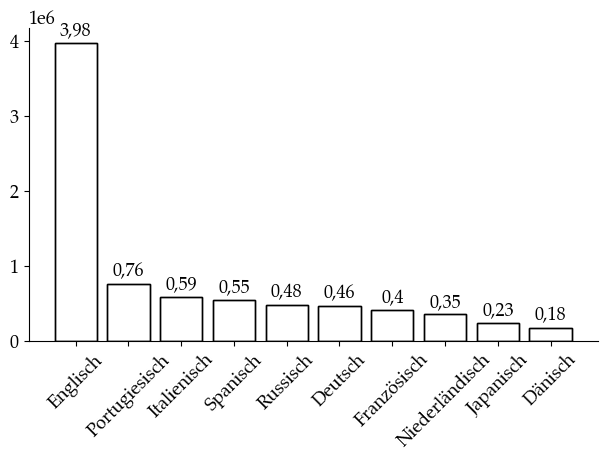

In [15]:
data_var = df_rev.len_code.value_counts().head(n=10)
data_var.index = ['Englisch', 'Portugiesisch', 'Italienisch', 'Spanisch', 'Russisch',
                  'Deutsch', 'Französisch', 'Niederländisch', 'Japanisch', 'Dänisch']
fig, ax = plt.subplots()
ax.bar(
    x=data_var.index,
    height=data_var.values,
    edgecolor='black', color='none'
)
plt.xticks(rotation=45)
bars = ax.bar(data_var.index,
              data_var.values,
              edgecolor='black', color='none')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('')
container = ax.containers[0]
ax.bar_label(container,
             labels=[str.replace(str(np.round(x / 1000000, decimals=2)), '.', ',') for x in container.datavalues],
             padding=2)
# ax.bar_label(bars, padding=3)
fig.tight_layout()
fig.savefig(fig_path + 'language_distribution.pdf')

In [9]:
top_10_order = list(df_rev.len_code.value_counts().head(n=10).index)
top_10_order

['en', 'pt', 'it', 'es', 'ru', 'de', 'fr', 'nl', 'ja', 'da']

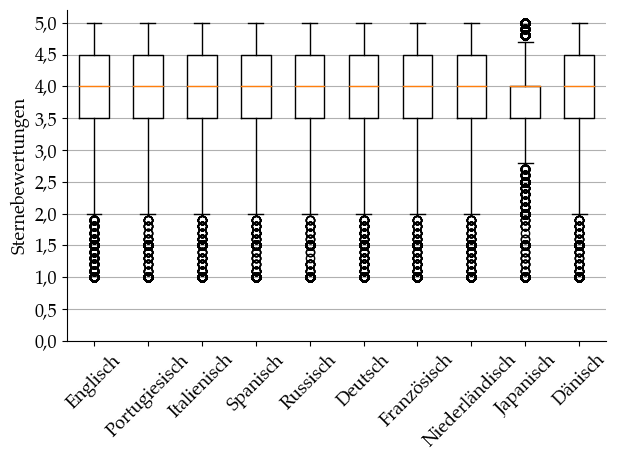

In [14]:
fig, ax = plt.subplots()
df = df_rev[df_rev.len_code.isin(top_10_order)][['len_code', 'rating']]
for position, column in enumerate(top_10_order):
    plot_var = ax.boxplot(df[df.len_code == column].rating, positions=[position], widths=0.55)

ax.set_xticks(range(position + 1))
ax.set_xticklabels(top_10_order)
# ax.set_xlim(xmin=-0.5)
ax.set_xticklabels(['Englisch', 'Portugiesisch', 'Italienisch', 'Spanisch', 'Russisch',
                    'Deutsch', 'Französisch', 'Niederländisch', 'Japanisch', 'Dänisch'])
plt.xticks(rotation=45)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(axis='y')
ax.set_ylabel('Sternebewertungen')
ax.set_yticks([0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5])
plt.tight_layout()
plt.show()
fig.savefig(fig_path + 'top_10_review_count_ratings.png', dpi=300)

In [9]:
con_rev_sent = sqlite3.connect('../database/review_en_sentiment.db')
df_rev_sent = pd.read_sql_query("SELECT id, rating, sentiment, note_length, note FROM review_en_sentiment",
                                con_rev_sent)
df_rev_sent.head()

,id,rating,sentiment,note_length,note
0,3975,4.0,0.938549,4,excellent full bodied wine
1,4202,5.0,0.576068,39,the real price at phillipson is around 1299 dk...
2,4261,5.0,0.982237,17,"clean, crisp and full of nuance and elegance, ..."
3,4264,4.0,0.576195,22,"crisp and clean champagne, a certain fave amon..."
4,4354,4.0,0.736812,12,it is not a champagne type wine! it is a red w...


In [10]:
n = 25000
df = df_rev_sent.sample(n=n)

In [38]:
correct_sent = {
    1.0: -1.0,
    1.5: -0.75,
    2.0: -0.5,
    2.5: -0.25,
    3.0: 0,
    3.5: 0.25,
    4.0: 0.5,
    4.5: 0.75,
    5.0: 1
}

df_correct = pd.DataFrame()

for rating in correct_sent.keys():
    sent = correct_sent[rating]
    df_correct = pd.concat(
        [df_correct, df[(df.rating == rating) & ((df.sentiment <= sent + 0.1) & (df.sentiment >= sent - 0.1))]])
df_correct.head()

,id,rating,sentiment,note_length,note
993731,65296517,1.0,-0.911612,6,"disappointing, strange and too intense. metallic."
2809782,185149095,1.0,-0.913273,7,"must have gone bad, this is terrible"
1280744,84840417,1.0,-0.933147,25,"this has no qualities of a cab whatsoever, it ..."
2678229,176426302,1.0,-0.911104,5,shitty wine with low quality
245063,18372830,1.0,-0.924342,8,unfortunately the wine was too old......damn d...


In [39]:
df_incorrect = df[~df.id.isin(df_correct.id)]
df_incorrect.head()

,id,rating,sentiment,note_length,note
3925491,253706325,3.0,-0.528974,26,"medium pink color, hint of orange. nose of ove..."
2380679,156629697,4.5,0.963727,15,"wine evenings with friends leather, oak, cedar..."
544534,35884335,4.0,0.956674,2,delicious wine
2835285,186828812,3.5,0.868941,8,a good spicy blend with red fruit dominance.
1004547,66012348,4.0,0.601349,19,need to let it breath for awhile. first taste ...


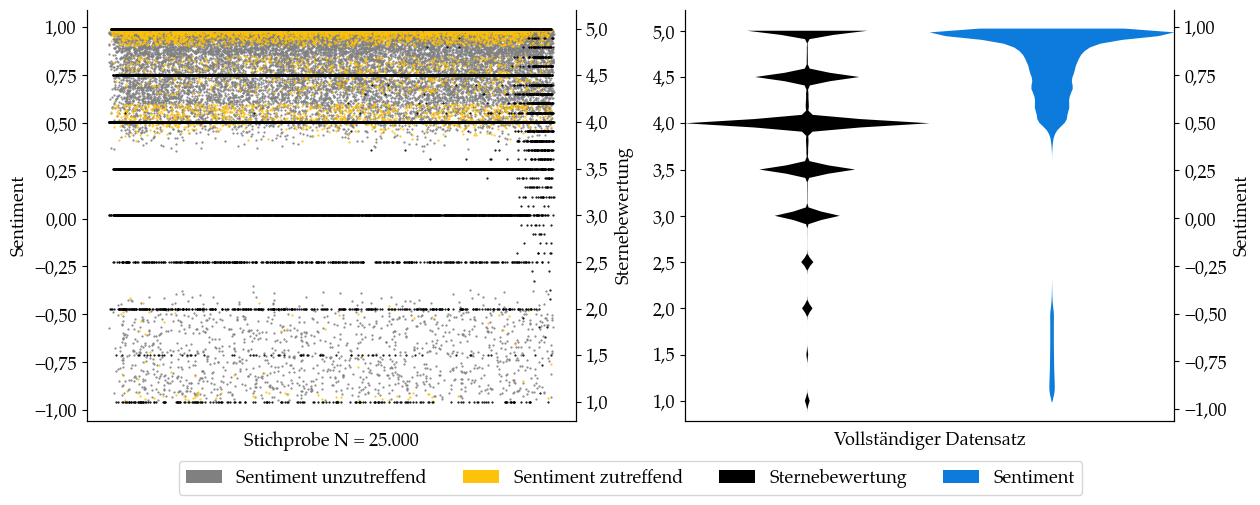

In [57]:


# Initialize subplots
fig, (ax1_1, ax2_1) = plt.subplots(nrows=1, ncols=2, figsize=(12.8, 4.8))

# First plot
ax1_2 = ax1_1.twinx()
ax1_1.scatter(x=df_incorrect.id, y=df_incorrect.sentiment, c='grey', s=0.3)
ax1_1.scatter(x=df_correct.id, y=df_correct.sentiment, c='#FFC20A', s=0.3)
ax1_2.scatter(x=df.id, y=df.rating, c='black', s=0.3)
ax1_1.set_ylabel('Sentiment')
ax1_2.set_ylabel('Sternebewertung')
ax1_2.set_xticks([])
ax1_1.set_xticklabels([])
ax1_1.set_xlabel('Stichprobe N = 25.000')
ax1_1.spines['top'].set_visible(False)
ax1_2.spines['top'].set_visible(False)

# Second plot
ax2_2 = ax2_1.twinx()
p1 = ax2_1.violinplot(df_rev_sent.rating, positions=[0.5], showextrema=False)
p2 = ax2_2.violinplot(df_rev_sent.sentiment, positions=[1], showextrema=False)

for pc in p1['bodies']:
    pc.set_facecolor('black')
    pc.set_alpha(1)
for pc in p2['bodies']:
    pc.set_facecolor('#0C7BDC')
    pc.set_alpha(1)
ax2_1.spines['top'].set_visible(False)
ax2_2.spines['top'].set_visible(False)

ax2_1.set_xlim(0.25, 1.25)
ax2_1.set_xticks([])
ax2_1.set_ylim(ymin=0.785)

ax2_2.set_ylabel('Sentiment')
ax2_1.set_xlabel('Vollständiger Datensatz')

legened_elements = [
    Patch(facecolor='grey', label='Sentiment unzutreffend'),
    Patch(facecolor='#FFC20A', label='Sentiment zutreffend'),
    Patch(facecolor='black', label='Sternebewertung'),
    Patch(facecolor='#0C7BDC', label='Sentiment')
]

fig.legend(handles=legened_elements, loc='lower center', bbox_to_anchor=(0.25, -0.07, 0.5, 0.5), ncol=4)
fig.tight_layout()
fig.savefig(fig_path + 'sentiment_rating.png', bbox_inches='tight', dpi=400)

In [58]:
print('Min: ' + str(df_incorrect.note_length.min()))
print('Median: ' + str(df_incorrect.note_length.median()))
print('Mean: ' + str(df_incorrect.note_length.mean()))
print('Max: ' + str(df_incorrect.note_length.max()))
print('\n')
print('Min: ' + str(df_correct.note_length.min()))
print('Median: ' + str(df_correct.note_length.median()))
print('Mean: ' + str(df_correct.note_length.mean()))
print('Max: ' + str(df_correct.note_length.max()))

Min: 1
Median: 9.0
Mean: 15.53471304858359
Max: 106


Min: 1
Median: 7.0
Mean: 12.819337864503398
Max: 97


In [60]:
len(df_incorrect)

20439

In [52]:
print(df_correct[df_correct.rating <= 2].note_length.median())
print(df_incorrect[df_incorrect.rating <= 2].note_length.median())

8.0
7.0


In [3]:
con_rev_en_sent = sqlite3.connect('../database/review_en_sentiment.db')
df_rev_en_sent = pd.read_sql_query("SELECT * FROM review_en_sentiment", con_rev_en_sent)
df_rev_en_sent.head()

,index,id,wine_id,rating,note,created_at,likes_count,comments_count,scan_image_path,user_id,note_length,len_code,sentiment
0,0,3975,1101258,4.0,excellent full bodied wine,2011-07-19T21:21:22.000Z,2.0,1.0,images.vivino.com/labels/1309631550_2382.jpg,32547,4,en,0.938549
1,1,4202,76378,5.0,the real price at phillipson is around 1299 dk...,2011-08-06T20:52:53.000Z,0.0,1.0,images.vivino.com/labels/1311959128_1819.jpg,48500,39,en,0.576068
2,2,4261,1231210,5.0,"clean, crisp and full of nuance and elegance, ...",2011-08-11T08:06:39.000Z,3.0,1.0,images.vivino.com/labels/1312622458_6592.jpg,53601,17,en,0.982237
3,3,4264,1178663,4.0,"crisp and clean champagne, a certain fave amon...",2011-08-11T09:28:07.000Z,25.0,2.0,images.vivino.com/labels/1312966707_6129.jpg,53601,22,en,0.576195
4,4,4354,17998,4.0,it is not a champagne type wine! it is a red w...,2011-08-12T16:53:19.000Z,0.0,1.0,images.vivino.com/labels/1311842730_8268.jpg,47873,12,en,0.736812


In [3]:
emojis = [c for c in df_rev_en_sent.note if c in emoji.EMOJI_DATA]
emojis.sort()
emoji_frequency = Counter(emojis)
emoji_frequency = {k: v for k, v in sorted(emoji_frequency.items(), key=lambda item: item[1])}
emoji_frequency

{'↗': 1,
 '⏱': 1,
 '☘': 1,
 '☘️': 1,
 '☯️': 1,
 '☹': 1,
 '⚠️': 1,
 '✌🏿': 1,
 '🇨🇭': 1,
 '🇭🇷': 1,
 '🇸🇮': 1,
 '🌃': 1,
 '🌅': 1,
 '🌈': 1,
 '🌚': 1,
 '🌩': 1,
 '🌰': 1,
 '🌱': 1,
 '🌵': 1,
 '🍗': 1,
 '🍜': 1,
 '🍦': 1,
 '🍸': 1,
 '🎅': 1,
 '🎅🏿': 1,
 '🎨': 1,
 '🏊': 1,
 '🏯': 1,
 '🏴\U000e0067\U000e0062\U000e0077\U000e006c\U000e0073\U000e007f': 1,
 '🐈': 1,
 '🐞': 1,
 '🐢': 1,
 '🐥': 1,
 '🐦': 1,
 '🐵': 1,
 '🐸': 1,
 '🐽': 1,
 '👆🏻': 1,
 '👈🏻': 1,
 '👞': 1,
 '👨🏻\u200d💻': 1,
 '👨🏿\u200d🎨': 1,
 '👼': 1,
 '💁🏻': 1,
 '💪🏿': 1,
 '🖖': 1,
 '🖖🏼': 1,
 '🖖🏾': 1,
 '🚑': 1,
 '🚬': 1,
 '🛂': 1,
 '🤎': 1,
 '🤴🏻': 1,
 '🤸': 1,
 '🥀': 1,
 '🥝': 1,
 '\U0001f977🏻': 1,
 '🦁': 1,
 '🦌': 1,
 '🦒': 1,
 '🦮': 1,
 '🧁': 1,
 '🧮': 1,
 '🩳': 1,
 '\U0001faa8': 1,
 '\U0001faf6': 1,
 '✌🏾': 2,
 '🍀': 2,
 '🍰': 2,
 '🎩': 2,
 '🏺': 2,
 '🐚': 2,
 '🐯': 2,
 '👁': 2,
 '👩🏼\u200d🤝\u200d👨🏿': 2,
 '💅🏻': 2,
 '💰': 2,
 '🔞': 2,
 '🖐': 2,
 '🗡': 2,
 '😤': 2,
 '🤏': 2,
 '🥤': 2,
 '\U0001f979': 2,
 '🦀': 2,
 '🦧': 2,
 '\U0001faf6🏻': 2,
 '🇦🇷': 3,
 '🎂': 3,
 '🏅': 3,
 '🐂': 3,
 '💎': 3,
 '💐': 3,
 '💪🏾':

In [4]:
df_emoji = pd.DataFrame(
    {
        'emoji': ['👍', '😍', '👌', '🍷', '🤩', '🥂', '♥️', '😘', '😁', '💪'],
        'count': [1564, 958, 566, 379, 254, 228, 176, 145, 127, 73]
    }
)
for index in df_emoji.index:
    name = emoji.demojize(df_emoji.emoji[index]).replace(':', '').replace('_', ' ')
    df_emoji.loc[index, 'name'] = name
    words = name.split()
    initials = ''
    for word in words:
        initials += word[0]
    df_emoji.loc[index, 'initials'] = initials.upper()

df_emoji.head()

,emoji,count,name,initials
0,👍,1564,thumbs up,TU
1,😍,958,smiling face with heart-eyes,SFWH
2,👌,566,OK hand,OH
3,🍷,379,wine glass,WG
4,🤩,254,star-struck,S


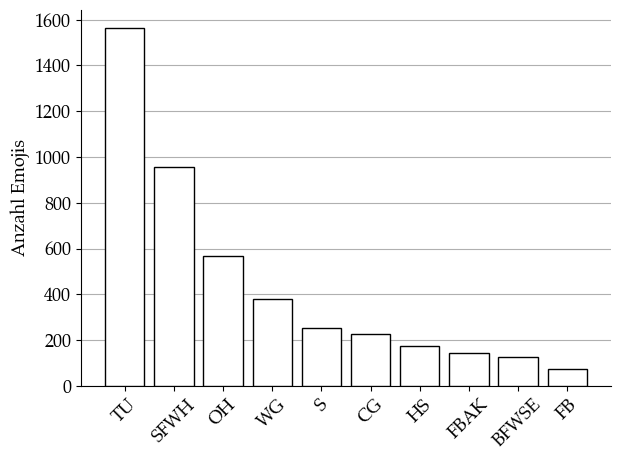

In [151]:
fig, ax = plt.subplots()
ax.bar(
    x=df_emoji.initials,
    height=df_emoji['count'],
    color='white',
    edgecolor='black',
    zorder=3
)
plt.xticks(rotation=45)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(axis='y')
ax.set_ylabel('Anzahl Emojis')
plt.tight_layout()
fig.savefig(fig_path + 'en_emojis_count.pdf')

In [5]:
for index in df_emoji.index:
    cols = df_rev_en_sent[df_rev_en_sent.note.str.contains(df_emoji['emoji'][index])][['sentiment', 'rating']]
    df_emoji.loc[index, 'sentiment'] = cols['sentiment'].mean()
    df_emoji.loc[index, 'rating'] = cols['rating'].mean()
df_emoji

,emoji,count,name,initials,sentiment,rating
0,👍,1564,thumbs up,TU,0.903300,4.178832
1,😍,958,smiling face with heart-eyes,SFWH,0.931466,4.515950
2,👌,566,OK hand,OH,0.914132,4.298683
3,🍷,379,wine glass,WG,0.851377,4.153922
4,🤩,254,star-struck,S,0.942198,4.443710
5,🥂,228,clinking glasses,CG,0.890130,4.049958
6,♥️,176,heart suit,HS,0.930766,4.547641
7,😘,145,face blowing a kiss,FBAK,0.905663,4.322985
8,😁,127,beaming face with smiling eyes,BFWSE,0.881481,4.085305
9,💪,73,flexed biceps,FB,0.871469,4.292006


In [8]:
df_emoji.to_csv('/Users/leonbecker/Desktop/emoji_dataframe.csv')

In [6]:
df_rev_en_sent.created_at[0]

'2011-07-19T21:21:22.000Z'

### Find a suitable way to reduce dataset for evaluation

In [12]:
df_rev_en_sent = load_from_database(db='review_en_sentiment', table='review_en_sentiment',
                                    columns='user_id, wine_id, rating, note_length')


In [13]:
var_min = 5
var_max = 1000
five_to_x_wines = df_rev_en_sent[df_rev_en_sent['wine_id'].isin(df_rev_en_sent['wine_id'].value_counts()[
                                                                    (df_rev_en_sent[
                                                                         'wine_id'].value_counts() >= var_min) &
                                                                    (df_rev_en_sent[
                                                                         'wine_id'].value_counts() <= var_max)
                                                                    ].index)]['wine_id']
five_to_x_wines.drop_duplicates(inplace=True)

/var/folders/0w/wzymnpfd4rjdkg4k8khhk6dc0000gn/T/ipykernel_53725/1316026233.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  five_to_x_wines.drop_duplicates(inplace=True)


In [14]:
df_rev_en_sent = df_rev_en_sent[
    df_rev_en_sent['wine_id'].isin(five_to_x_wines)
]

In [15]:
len(set(df_rev_en_sent['user_id']))

638235

In [16]:
test, train = train_test_split(df_rev_en_sent, test_size=0.8, random_state=26)

In [17]:
def split(a, n):
    k, m = divmod(len(a), n)
    return list(a[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(n))

In [18]:
evaluation_wines = set()
core_count = 10
df_results = pd.DataFrame()
user_ids = df_rev_en_sent['user_id'].unique()
user_ids_frames = split(a=user_ids, n=core_count)

with concurrent.futures.ProcessPoolExecutor() as executor:
    results = [
        executor.submit(count_corresponding_reviews.count_corresponding_reviews, [train, test, user_ids_frames[i]]) for
        i in
        range(core_count)]

    for result in concurrent.futures.as_completed(results):
        df_results = pd.concat([df_results, result.result()])

In [19]:
print('Users considered in evaluation: ', len(df_results[df_results['corresponding_reviews_evaluation'] > 0]))
print('corresponding_reviews_evaluation: ', str(df_results['corresponding_reviews_evaluation'].sum()))
print('median corresponding reviews: ', str(df_results['median_note_length_cr'].median()))

Users considered in evaluation:  106167
corresponding_reviews_evaluation:  10584883
median corresponding reviews:  13.5


In [24]:
df_results[df_results['corresponding_reviews_evaluation'] > 0]['median_note_length_cr']

11       34.0
12       12.5
26       23.5
32       12.0
33       10.0
         ... 
63791    18.0
63792    14.0
63802     5.0
63809    19.5
63813    17.0
Name: median_note_length_cr, Length: 106167, dtype: float64

In [25]:
df_rev_en_sent['note_length'].median()

9.0

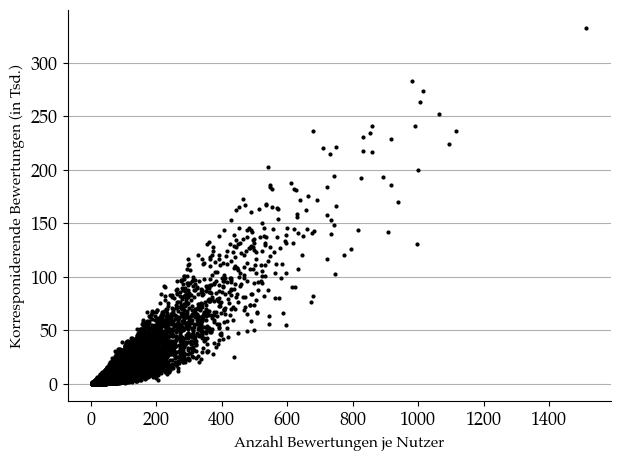

In [10]:
fig, ax = plt.subplots()
ax.scatter(
    x=df_results['reviews_count'],
    y=df_results['corresponding_reviews_evaluation'] / 1000,
    zorder=3,
    c='black',
    s=4
)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(axis='y')
ax.set_xlabel('Anzahl Bewertungen je Nutzer', fontsize=11)
ax.set_ylabel('Korresponiderende Bewertungen (in Tsd.)', fontsize=11)
plt.tight_layout()

fig.savefig(fig_path + 'korrespondierende_bewertung_wein.png', dpi=400)

In [32]:
intersection = list(set(test['user_id']) & set(train['user_id']))

In [33]:
len(np.unique(intersection))

49723

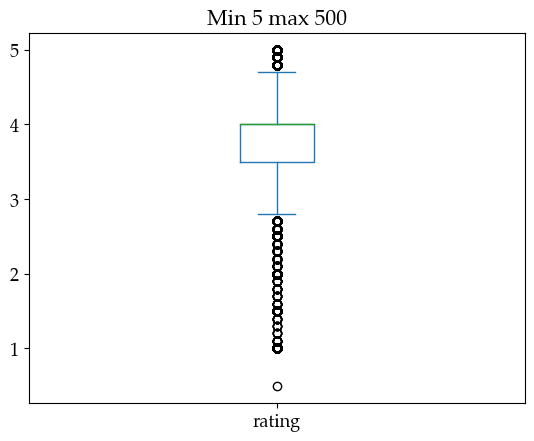

In [26]:
pd.concat([train[train['user_id'].isin(intersection)], test[test['user_id'].isin(intersection)]]).plot(
    kind='box',
    title='Min 5 max 500',
    y='rating'
)
plt.savefig(fig_path + 'Min 5 max 500.pdf')

In [10]:
pd.concat(
    [df_en_train[df_en_train['user_id'].isin(intersection)], df_en_test[df_en_test['user_id'].isin(intersection)]])

,user_id,wine_id,rating
0,9834827,6020,4.5
1,18567062,1571152,4.0
2,31205049,88008,4.0
3,1186276,3873573,4.0
4,4922852,82729,4.0
...,...,...,...
473086,13004943,73759,3.5
473087,22794732,15615,4.0
473088,13807358,1298777,4.0
473089,31914820,1713612,5.0


In [40]:
df_rev_en_sent = load_from_database(db='review_en_sentiment', table='review_en_sentiment',
                                    columns='user_id, wine_id, likes_count, note_length, comments_count')

In [91]:
df_rev_en_sent[df_rev_en_sent['likes_count'] > 0]['note_length'].median()

14.0

In [51]:
n = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
wines = list()
reviews = list()
length = list()
comments = list()
for i in n:
    df_temp = df_rev_en_sent[df_rev_en_sent['likes_count'] >= i]
    wines.append(len(df_temp['wine_id'].unique()) / len(df_rev_en_sent['wine_id'].unique()))
    reviews.append(len(df_temp) / len(df_rev_en_sent))
    length.append(df_rev_en_sent[df_rev_en_sent['likes_count'] >= i]['note_length'].median())
    comments.append(df_rev_en_sent[df_rev_en_sent['likes_count'] >= i]['comments_count'].median())
df_likes_count = pd.DataFrame({
    'n': n,
    'wines': wines,
    'reviews': reviews,
    'length_median': length,
    'comments_count': comments
})
df_likes_count

,n,wines,reviews,length_median,comments_count
0,0,1.000000,1.000000,9.0,0.0
1,1,0.995002,0.460326,14.0,0.0
2,2,0.988933,0.270818,20.0,0.0
3,3,0.983577,0.196159,24.0,0.0
4,4,0.979561,0.159682,26.0,0.0
5,5,0.976615,0.138580,27.0,1.0
6,6,0.973313,0.124656,28.0,1.0
7,7,0.971171,0.114370,29.0,2.0
8,8,0.969386,0.106329,30.0,2.0
9,9,0.966708,0.099666,31.0,2.0


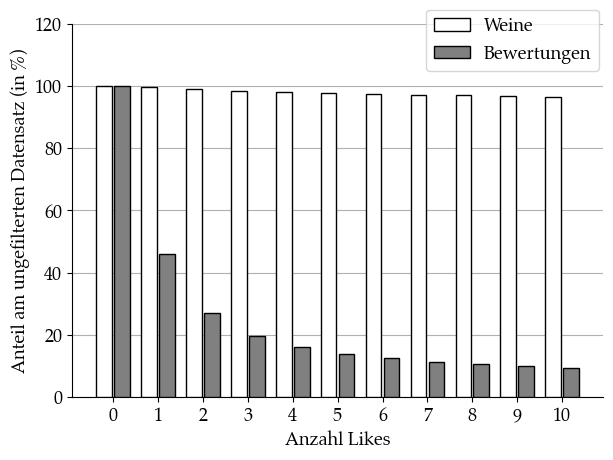

In [75]:
fig, ax = plt.subplots()
ax.bar(
    x=df_likes_count['n'] - 0.2,
    height=df_likes_count['wines'] * 100,
    align='center',
    width=0.35,
    zorder=3,
    edgecolor='black',
    color='white', label='Weine'
)
ax.bar(
    x=df_likes_count['n'] + 0.2,
    height=df_likes_count['reviews'] * 100,
    align='center',
    width=0.35,
    zorder=3,
    edgecolor='black',
    color='grey', label='Bewertungen'
)
ax.grid(axis='y')
ax.spines[['right', 'top']].set_visible(False)
ax.set_xlabel('Anzahl Likes')
ax.set_ylabel('Anteil am ungefilterten Datensatz (in %)')
ax.legend(bbox_to_anchor=(0.65, 0.85))
ax.set_yticks([0, 20, 40, 60, 80, 100, 120])
ax.set_xticks(list(range(11)))
fig.tight_layout()
fig.savefig(fig_path + 'likes_count_share.pdf')

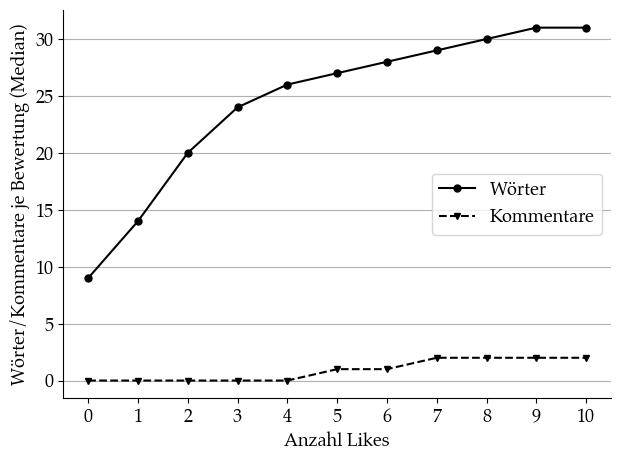

In [88]:
fig, ax = plt.subplots()

ax.plot(
    df_likes_count['n'],
    df_likes_count['length_median'],
    color='black',
    markersize=5,
    marker='o',
    label='Wörter'
)
ax.plot(
    df_likes_count['n'],
    df_likes_count['comments_count'],
    color='black',
    marker='v',
    markersize=5,
    linestyle='--',
    label='Kommentare'
)
ax.grid(axis='y')
ax.legend(loc='center right')
ax.spines[['right', 'top']].set_visible(False)
ax.set_xticks(list(range(11)))
ax.set_xlabel('Anzahl Likes')
ax.set_ylabel('Wörter/Kommentare je Bewertung (Median)')
fig.tight_layout()
fig.savefig(fig_path + 'words_comments_per_rating.pdf')

In [11]:
df_reduced_by_wine = pd.DataFrame(
    {
        'Maximum': ['∞', '10000', '8000', '6000', '4000', '2000', '1000', '500'],
        'Nutzende': [112075, 105737, 102432, 97954, 89356, 68253, 49728, 31604],
        'Weine': [11025, 11011, 10999, 10978, 10918, 10650, 10173, 9202],
        'Korrespondierende Bewertungen': [2158407908, 1677124712, 1500279337, 1275135930, 890434573, 383378808,
                                          163662979, 53732255],
        'Korrespondierende Bewertungen Eval.': [201106543, 160515649, 145516083, 124702742, 77465425, 27545146,
                                                10400615, 2875502],
        'Dauer': [558.63, 445.88, 404.21, 346.4, 215.18, 76.51, 28.89, 7.99]
    }
)
df_reduced_by_wine

,Maximum,Nutzende,Weine,Korrespondierende Bewertungen,Korrespondierende Bewertungen Eval.,Dauer
0,∞,112075,11025,2158407908,201106543,558.63
1,10000,105737,11011,1677124712,160515649,445.88
2,8000,102432,10999,1500279337,145516083,404.21
3,6000,97954,10978,1275135930,124702742,346.40
4,4000,89356,10918,890434573,77465425,215.18
5,2000,68253,10650,383378808,27545146,76.51
6,1000,49728,10173,163662979,10400615,28.89
7,500,31604,9202,53732255,2875502,7.99


In [9]:
np.round(
    9202 / 11025, decimals=4
) * 100

83.46000000000001

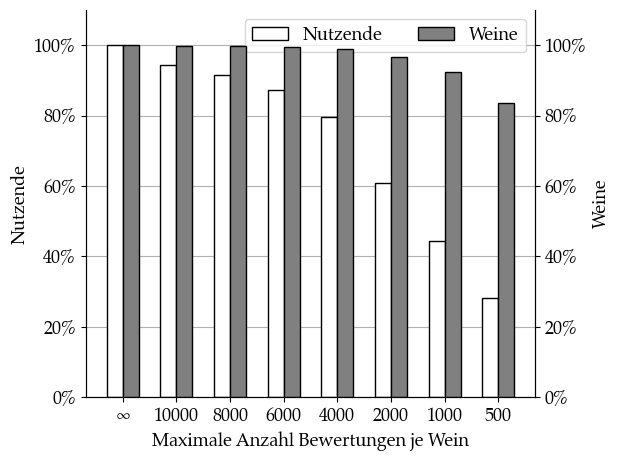

In [26]:
import matplotlib.ticker as mtick

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

x = np.arange(len(df_reduced_by_wine['Maximum']))
width = 0.3

ax1.bar(
    x=x - 0.15,
    height=df_reduced_by_wine['Nutzende'] / df_reduced_by_wine['Nutzende'].max() * 100,
    edgecolor='black',
    color='white',
    zorder=2,
    width=width
)
ax2.bar(
    x=x + 0.15,
    height=df_reduced_by_wine['Weine'] / df_reduced_by_wine['Weine'].max() * 100,
    edgecolor='black',
    color='grey',
    zorder=2,
    width=width
)

ax1.set_xticks(x, df_reduced_by_wine['Maximum'])
ax1.set_ylabel('Nutzende')
ax2.set_ylabel('Weine')
ax1.set_xlabel('Maximale Anzahl Bewertungen je Wein')
ax2.set_ylim(0, 110)
ax1.set_ylim(0, 110)
ax1.yaxis.set_major_formatter(mtick.PercentFormatter())
ax2.yaxis.set_major_formatter(mtick.PercentFormatter())
ax1.grid(axis='y')
legend_elements = [
    Patch(facecolor='white', edgecolor='black', label='Nutzende'),
    Patch(facecolor='grey', edgecolor='black', label='Weine')
]
ax1.spines[['top']].set_visible(False)
ax2.spines[['top']].set_visible(False)
ax1.legend(handles=legend_elements, ncol=2)
fig.tight_layout()
fig.savefig(fig_path + 'nutzende_weine_max_weine.pdf')

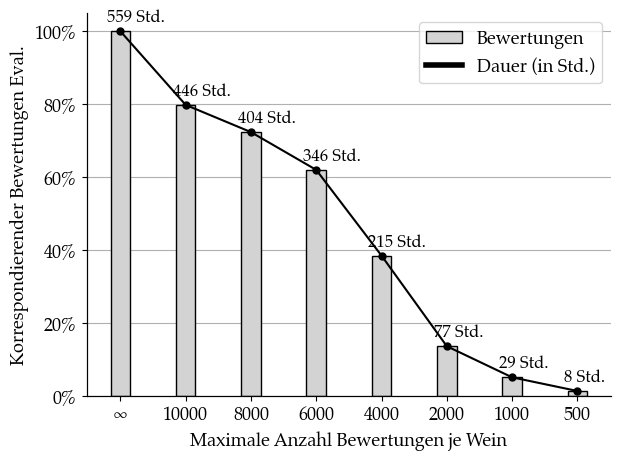

In [29]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

x = np.arange(len(df_reduced_by_wine['Maximum']))
width = 0.3

ax1.bar(
    x=x,
    height=df_reduced_by_wine['Korrespondierende Bewertungen Eval.'] / df_reduced_by_wine[
        'Korrespondierende Bewertungen Eval.'].max() * 100,
    edgecolor='black',
    color='lightgrey',
    zorder=2,
    width=width
)
ax2.plot(
    x,
    df_reduced_by_wine['Dauer'],
    zorder=2,
    color='black',
    markersize=5,
    marker='o',
)
ax2.set_xticks(x, df_reduced_by_wine['Maximum'])
for i in range(len(df_reduced_by_wine['Maximum'])):
    label = str(round(df_reduced_by_wine.loc[i, 'Dauer'])) + ' Std.'
    x = i - 0.2
    y = df_reduced_by_wine.loc[i, 'Dauer'] + 15
    ax2.annotate(
        label, (x, y), zorder=4, fontsize=12
    )

legend_elements = [
    Patch(facecolor='lightgrey', edgecolor='black', label='Bewertungen'),
    Line2D([0], [0], color='black', lw=4, label='Dauer (in Std.)')
]
ax1.grid(axis='y')
ax1.spines[['right', 'top']].set_visible(False)
ax2.spines[['right', 'top']].set_visible(False)
ax2.set_ylim(ymin=0)
ax2.set_yticklabels('')
ax2.set_yticks([])
ax1.set_ylabel('Korrespondierender Bewertungen Eval.')
ax1.set_xlabel('Maximale Anzahl Bewertungen je Wein')
ax1.yaxis.set_major_formatter(mtick.PercentFormatter())
ax1.legend(handles=legend_elements, ncol=1)
fig.tight_layout()
fig.savefig(fig_path + 'korrespondierende_bewertungen_dauer_max_weine.pdf')

### Predictions

In [4]:
df_preds_zero_shot = load_from_database(db='predictions', table='zero_shot',
                                        columns='user_id, wine_id, prediction, rating')

In [5]:
from sklearn.metrics import mean_squared_error

In [6]:
def group_rmse(group):
    return mean_squared_error(y_pred=group['prediction'], y_true=group['rating'], squared=False)


def group_mse(group):
    return mean_squared_error(y_pred=group['prediction'], y_true=group['rating'])

In [7]:
df_zero_shot_rmse = pd.DataFrame(df_preds_zero_shot.groupby(by=['user_id', 'wine_id']).apply(func=group_rmse))
df_zero_shot_rmse = df_zero_shot_rmse.merge(df_preds_zero_shot.groupby(by=['user_id', 'wine_id'])['rating'].median(),
                                            left_index=True, right_index=True)

In [8]:
df_zero_shot_mse = pd.DataFrame(df_preds_zero_shot.groupby(by=['user_id', 'wine_id']).apply(func=group_mse))
df_zero_shot_mse = df_zero_shot_mse.merge(df_preds_zero_shot.groupby(by=['user_id', 'wine_id'])['rating'].median(),
                                          left_index=True, right_index=True)

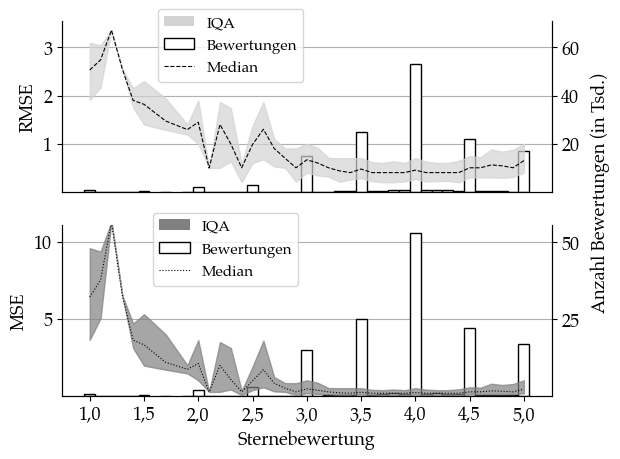

In [220]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1)

ax1_1 = ax1.twinx()
ax2_1 = ax2.twinx()

ax1.fill_between(
    x=df_zero_shot_rmse.sort_values(by='rating')['rating'].unique(),
    y1=df_zero_shot_rmse.sort_values(by='rating').groupby(by='rating').quantile(q=0.75)[0],
    y2=df_zero_shot_rmse.sort_values(by='rating').groupby(by='rating').quantile(q=0.25)[0],
    color='lightgrey',
    alpha=0.7,
    zorder=1
)
ax1.plot(
    df_zero_shot_rmse.sort_values(by='rating')['rating'].unique(),
    df_zero_shot_rmse.sort_values(by='rating').groupby(by='rating').median(),
    c='black',
    linewidth=0.8,
    linestyle='--',
)
ax1_1.bar(
    df_zero_shot_rmse.sort_values(by='rating')['rating'].unique(),
    df_zero_shot_rmse['rating'].value_counts().sort_index() / 1000,
    color='white',
    edgecolor='black',
    width=0.1,
    zorder=2
)
ax1.patch.set_visible(False)
ax1.set_zorder(ax1_1.get_zorder() + 1)

ax2.plot(
    df_zero_shot_mse.sort_values(by='rating')['rating'].unique(),
    df_zero_shot_mse.sort_values(by='rating').groupby(by='rating').median(),
    c='black',
    linestyle=':',
    linewidth=0.8,
    zorder=3
)

ax2.fill_between(
    x=df_zero_shot_mse.sort_values(by='rating')['rating'].unique(),
    y1=df_zero_shot_mse.sort_values(by='rating').groupby(by='rating').quantile(q=0.75)[0],
    y2=df_zero_shot_mse.sort_values(by='rating').groupby(by='rating').quantile(q=0.25)[0],
    color='grey',
    alpha=0.7,
    zorder=2
)

ax2_1.bar(
    df_zero_shot_mse.sort_values(by='rating')['rating'].unique(),
    df_zero_shot_mse['rating'].value_counts().sort_index() / 1000,
    color='white',
    edgecolor='black',
    width=0.1,
    zorder=2
)
ax2.patch.set_visible(False)
ax2.set_zorder(ax2_1.get_zorder() + 1)

ax1.legend(handles=[
    Patch(facecolor='lightgrey', label='IQA'),
    Patch(facecolor='white', edgecolor='black', label='Bewertungen'),
    Line2D([0], [0], color='black', linestyle='--', lw=0.8, label='Median')
], ncols=1, bbox_to_anchor=(0.18, 0.6), fontsize=11)
ax2.legend(handles=[
    Patch(facecolor='grey', label='IQA'),
    Patch(facecolor='white', edgecolor='black', label='Bewertungen'),
    Line2D([0], [0], color='black', linestyle=':', lw=0.8, label='Median')
], bbox_to_anchor=(0.17, 0.6), ncols=1, fontsize=11)

ax1.spines[['top']].set_visible(False)
ax1_1.spines[['top']].set_visible(False)
ax1.set_xticks([1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5])
ax1.set_xticks([])
ax2.set_xticks([1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5])
ax2.margins(y=0)
#ax2_1.margins(y=0)
ax2.set_yticks([5, 10])
ax2_1.set_yticks([25, 50])
ax1_1.set_ylim(0, 71)
ax2.set_ylim(0, 11.1)
ax1.set_yticks([1, 2, 3])
ax1.set_ylim(0, 3.55)
ax1_1.set_yticks([20, 40, 60])
ax1.set_ylabel('RMSE')
ax1_1.set_ylabel('Anzahl Bewertungen (in Tsd.)')
ax1_1.yaxis.set_label_coords(1.08, 0.0001)
ax2.set_ylabel('MSE')
ax2.set_xlabel('Sternebewertung')
ax2.spines[['top']].set_visible(False)
ax2_1.spines[['top']].set_visible(False)
fig.tight_layout()
ax1_1.grid(axis='y')
ax2_1.grid(axis='y')
fig.savefig(fig_path + 'density_zero-shot.pdf')

In [12]:
df_preds_numeric = load_from_database(db='predictions', table='numeric',
                                      columns='user_id, wine_id, prediction, rating')

In [13]:
df_preds_numeric_rmse = pd.DataFrame(df_preds_numeric.groupby(by=['user_id', 'wine_id']).apply(func=group_rmse))
df_preds_numeric_rmse = df_preds_numeric_rmse.merge(
    df_preds_numeric.groupby(by=['user_id', 'wine_id'])['rating'].median(),
    left_index=True, right_index=True)
df_preds_numeric_mse = pd.DataFrame(df_preds_numeric.groupby(by=['user_id', 'wine_id']).apply(func=group_mse))
df_preds_numeric_mse = df_preds_numeric_mse.merge(
    df_preds_numeric.groupby(by=['user_id', 'wine_id'])['rating'].median(),
    left_index=True, right_index=True)

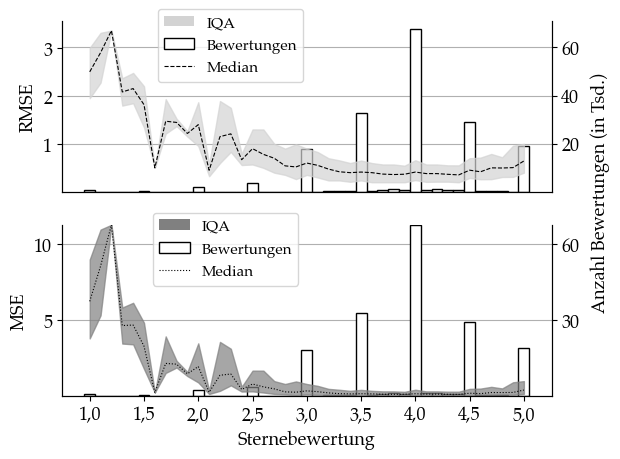

In [219]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1)

ax1_1 = ax1.twinx()
ax2_1 = ax2.twinx()

ax1.fill_between(
    x=df_preds_numeric_rmse.sort_values(by='rating')['rating'].unique(),
    y1=df_preds_numeric_rmse.sort_values(by='rating').groupby(by='rating').quantile(q=0.75)[0],
    y2=df_preds_numeric_rmse.sort_values(by='rating').groupby(by='rating').quantile(q=0.25)[0],
    color='lightgrey',
    alpha=0.7,
    zorder=1
)
ax1.plot(
    df_preds_numeric_rmse.sort_values(by='rating')['rating'].unique(),
    df_preds_numeric_rmse.sort_values(by='rating').groupby(by='rating').median(),
    c='black',
    linewidth=0.8,
    linestyle='--',
)
ax1_1.bar(
    df_preds_numeric_rmse.sort_values(by='rating')['rating'].unique(),
    df_preds_numeric_rmse['rating'].value_counts().sort_index() / 1000,
    color='white',
    edgecolor='black',
    width=0.1,
    zorder=2
)
ax1.patch.set_visible(False)
ax1.set_zorder(ax1_1.get_zorder() + 1)

ax2.plot(
    df_preds_numeric_mse.sort_values(by='rating')['rating'].unique(),
    df_preds_numeric_mse.sort_values(by='rating').groupby(by='rating').median(),
    c='black',
    linestyle=':',
    linewidth=0.8,
    zorder=3
)

ax2.fill_between(
    x=df_preds_numeric_mse.sort_values(by='rating')['rating'].unique(),
    y1=df_preds_numeric_mse.sort_values(by='rating').groupby(by='rating').quantile(q=0.75)[0],
    y2=df_preds_numeric_mse.sort_values(by='rating').groupby(by='rating').quantile(q=0.25)[0],
    color='grey',
    alpha=0.7,
    zorder=2
)

ax2_1.bar(
    df_preds_numeric_mse.sort_values(by='rating')['rating'].unique(),
    df_preds_numeric_mse['rating'].value_counts().sort_index() / 1000,
    color='white',
    edgecolor='black',
    width=0.1,
    zorder=2
)
ax2.patch.set_visible(False)
ax2.set_zorder(ax2_1.get_zorder() + 1)

ax1.legend(handles=[
    Patch(facecolor='lightgrey', label='IQA'),
    Patch(facecolor='white', edgecolor='black', label='Bewertungen'),
    Line2D([0], [0], color='black', linestyle='--', lw=0.8, label='Median')
], ncols=1, bbox_to_anchor=(0.18, 0.6), fontsize=11)
ax2.legend(handles=[
    Patch(facecolor='grey', label='IQA'),
    Patch(facecolor='white', edgecolor='black', label='Bewertungen'),
    Line2D([0], [0], color='black', linestyle=':', lw=0.8, label='Median')
], bbox_to_anchor=(0.17, 0.6), ncols=1, fontsize=11)

ax1.spines[['top']].set_visible(False)
ax1_1.spines[['top']].set_visible(False)
ax1.set_xticks([1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5])
ax1.set_xticks([])
ax2.set_xticks([1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5])
ax2.margins(y=0)
ax2_1.margins(y=0)
#ax1_1.margins(y=0)
#ax1.margins(y=0)
ax1.set_ylabel('RMSE')
ax1_1.set_ylabel('Anzahl Bewertungen (in Tsd.)')
ax1_1.yaxis.set_label_coords(1.08, 0.0001)
ax2.set_ylabel('MSE')
ax2_1.set_yticks([30, 60])
ax1_1.set_yticks([20, 40, 60])
ax1.set_yticks([1, 2, 3])
ax1.set_ylim(0, 3.56)

ax2.spines[['top']].set_visible(False)
ax2_1.spines[['top']].set_visible(False)
ax2.set_xlabel('Sternebewertung')
fig.tight_layout()
ax1_1.grid(axis='y')
ax2_1.grid(axis='y')
fig.savefig(fig_path + 'density_numeric.pdf')

### Cold-start scenario

In [249]:
df_preds_simcse_sc = load_from_database(db='predictions', table='nlp_simcse_en_sc',
                                        columns='user_id, wine_id, prediction, rating')
df_preds_simcse_rmse_sc = pd.DataFrame(
    df_preds_simcse_sc.groupby(by=['user_id', 'wine_id'], as_index=False).apply(func=group_rmse))
df_preds_simcse_rmse_sc = df_preds_simcse_rmse_sc.merge(
    df_preds_simcse_sc.groupby(by=['user_id', 'wine_id'], as_index=False)['rating'].median(), on=['wine_id', 'user_id'])

In [38]:
_min = 1
_max = 20
five_to_x = train[train['user_id'].isin(train['user_id'].value_counts()[
                                            (train['user_id'].value_counts() >= _min) &
                                            (train['user_id'].value_counts() <= _max)
                                            ].index)]['user_id']
five_to_x.drop_duplicates(inplace=True)

In [39]:
train = train[train['user_id'].isin(five_to_x)]

In [40]:
def split(a, n):
    k, m = divmod(len(a), n)
    return list(a[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(n))


evaluation_wines = set()
core_count = 10
df_results = pd.DataFrame()
user_ids = pd.concat([test, train])['user_id'].unique()
user_ids_frames = split(a=user_ids, n=core_count)

with concurrent.futures.ProcessPoolExecutor() as executor:
    results = [
        executor.submit(count_corresponding_reviews.count_corresponding_reviews, [train, test, user_ids_frames[i]]) for
        i in
        range(core_count)]

    for result in concurrent.futures.as_completed(results):
        df_results = pd.concat([df_results, result.result()])
print('Users considered in evaluation: ', len(df_results[df_results['corresponding_reviews_evaluation'] > 0]))
print('corresponding_reviews_evaluation: ', str(df_results['corresponding_reviews_evaluation'].sum()))
print('median_corresponding_reviews', str(df_results[df_results['corresponding_reviews_evaluation'] > 0].median()))
print('meancorresponding_reviews', str(df_results[df_results['corresponding_reviews_evaluation'] > 0].mean()))

In [41]:
q_25 = df_results[df_results['corresponding_reviews_evaluation'] > 0]['corresponding_reviews_evaluation'].quantile(
    q=0.25)
q_75 = df_results[df_results['corresponding_reviews_evaluation'] > 0]['corresponding_reviews_evaluation'].quantile(
    q=0.75)
q_75 - q_25

18.0

In [19]:
df_results[df_results['corresponding_reviews_evaluation'] > 0]['corresponding_reviews_evaluation'].mean()

9.766900077922354

In [45]:
df_coldstart = pd.DataFrame(
    {
        'lower_bound': [1, 1, 1, 1],
        'upper_bound': [10, 5, 15, 20],
        'user_count': [187366, 154805, 200776, 207949],
        'corresponding_review': [1829985, 700877, 3224234, 4886372],
        'median_corresponding_reviews': [4, 3, 5, 6],
        'mean_corresponding_reviews': [9.8, 4.5, 16.1, 24],
        'iqr': [8, 4, 13, 18]
    }
)

In [46]:
df_coldstart.sort_values(by='upper_bound')

,lower_bound,upper_bound,user_count,corresponding_review,median_corresponding_reviews,mean_corresponding_reviews,iqr
1,1,5,154805,700877,3,4.5,4
0,1,10,187366,1829985,4,9.8,8
2,1,15,200776,3224234,5,16.1,13
3,1,20,207949,4886372,6,24.0,18


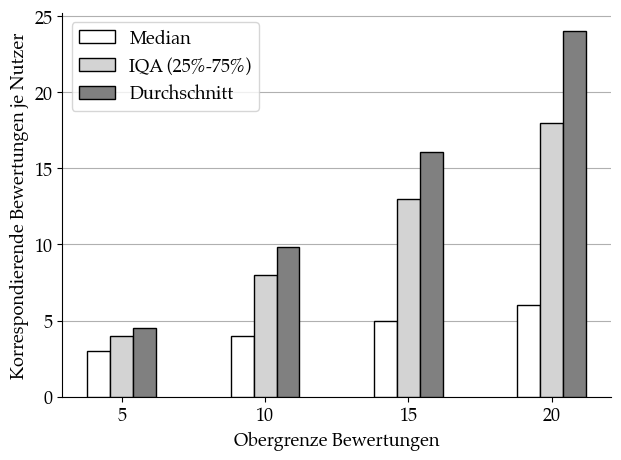

In [118]:
fig, ax = plt.subplots()

ax.bar(
    x=df_coldstart['upper_bound'] - 0.8,
    height=df_coldstart['median_corresponding_reviews'],
    color='white',
    edgecolor='black',
    label='Median',
    zorder=3
)
ax.bar(
    x=df_coldstart['upper_bound'],
    height=df_coldstart['iqr'],
    color='lightgrey',
    edgecolor='black',
    label='IQA (25%-75%)',
    zorder=3
)
ax.bar(
    x=df_coldstart['upper_bound'] + 0.8,
    height=df_coldstart['mean_corresponding_reviews'],
    color='grey',
    edgecolor='black',
    label='Durchschnitt',
    zorder=3
)
ax.legend()
ax.grid(axis='y')
ax.set_xlabel('Obergrenze Bewertungen')
ax.set_ylabel('Korrespondierende Bewertungen je Nutzer')
ax.set_xticks(df_coldstart['upper_bound'])
ax.spines[['top', 'right']].set_visible(False)
fig.tight_layout()
fig.savefig(fig_path + 'kaltstart_verteilung.pdf')

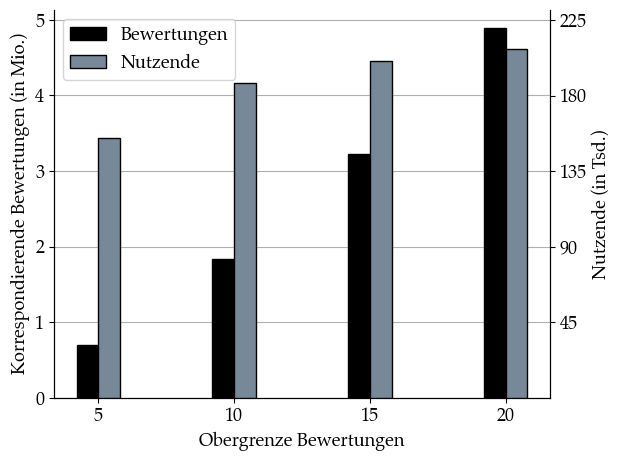

In [115]:
fig, ax = plt.subplots()

ax2 = ax.twinx()

ax.bar(
    x=df_coldstart['upper_bound']-0.4,
    height=df_coldstart['corresponding_review'] / 1000000,
    color='black',
    edgecolor='black',
    zorder=3
)
ax2.bar(
    x=df_coldstart['upper_bound']+0.4,
    height=df_coldstart['user_count'] / 1000,
    color='lightslategray',
    edgecolor='black',
    zorder=3
)
ax.legend(
    handles=[
        Patch(facecolor='black', edgecolor='black', label='Bewertungen'),
        Patch(facecolor='lightslategray', edgecolor='black', label='Nutzende')
    ]
)
ax.grid(axis='y')
ax.set_xticks(df_coldstart['upper_bound'])
ax2.set_ylim(0, 231)
ax2.set_yticks([45, 90, 135, 180, 225])
ax.set_xlabel('Obergrenze Bewertungen')
ax.set_ylabel('Korrespondierende Bewertungen (in Mio.)')
ax2.set_ylabel('Nutzende (in Tsd.)')
ax.spines[['top']].set_visible(False)
ax2.spines[['top']].set_visible(False)
fig.tight_layout()
fig.savefig(fig_path + 'kaltstart_bewertungen_nutzende.pdf')

### Cross-Domain Recommendation

In [14]:
df_en_train = load_from_database(db='review_en_train', table='review_en_train', columns='*')
df_en_test = load_from_database(db='review_en_test', table='review_en_test', columns='*')
df_wine = load_from_database(db='wine_distinct', table='wine_distinct', columns='id, type_id')

In [15]:
df_wine_types = pd.DataFrame({'type_id': wine_type_ids.keys(), 'wine_type': wine_type_ids.values()})
df_wine_types

,type_id,wine_type
0,1,Rotwein
1,2,Weißwein
2,3,Schaumwein
3,4,Rosé
4,24,Likörwein
5,7,Dessertwein


In [16]:
df_wine = df_wine.merge(df_wine_types, on='type_id')
df_wine.head()

,id,type_id,wine_type
0,617,1,Rotwein
1,639,1,Rotwein
2,657,1,Rotwein
3,953,1,Rotwein
4,1208,1,Rotwein


In [17]:
df_en_train = df_en_train.merge(df_wine, left_on='wine_id', right_on='id', how='left')
df_en_test = df_en_test.merge(df_wine, left_on='wine_id', right_on='id', how='left')

In [19]:
df_en_train.drop(columns=['wine_type', 'id_y', 'level_0', 'index'], inplace=True)
df_en_test.drop(columns=['wine_type', 'id_y', 'level_0', 'index'], inplace=True)

In [27]:
df_en_train.rename({'id_x': 'id'}, axis='columns', inplace=True)
df_en_test.rename({'id_x': 'id'}, axis='columns', inplace=True)

In [29]:
save_to_database(db='review_en_train', table='review_en_train', df=df_en_train)
save_to_database(db='review_en_test', table='review_en_test', df=df_en_test)

DataFrame has been saved successfully to: review_en_train
DataFrame has been saved successfully to: review_en_test


In [11]:
df_rev_en = pd.concat([df_en_train, df_en_test])
df_rev_en.head()

,user_id,wine_id,rating,id,wine_type
0,7312342,6161,4.0,6161,Rotwein
1,2640863,1172211,5.0,1172211,Rotwein
2,20563166,24210,3.0,24210,Weißwein
3,10444920,1703690,4.0,1703690,Schaumwein
4,46600738,77472,4.0,77472,Rotwein


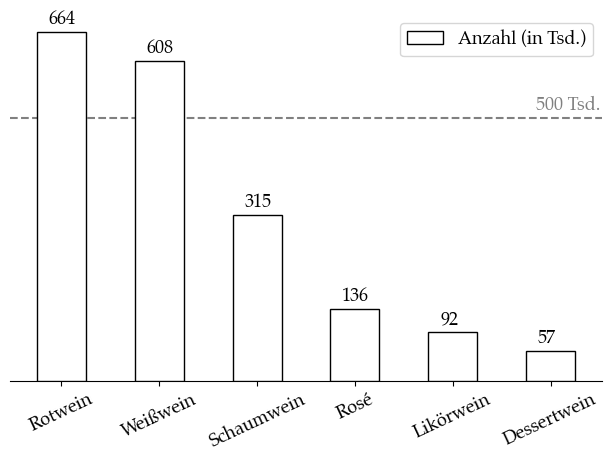

In [104]:
fig, ax = plt.subplots()

ax.bar(
    x=df_rev_en['wine_type'].value_counts().index,
    height=df_rev_en['wine_type'].value_counts().values / 1000,
    width=0.5,
    color='white',
    edgecolor='black',
    label='Anzahl (in Tsd.)',
    zorder=3
)

for i in range(len(df_rev_en['wine_type'].value_counts().values)):
    label = str(round(df_rev_en['wine_type'].value_counts().values[i] / 1000))
    x = i - 0.13
    y = (df_rev_en['wine_type'].value_counts().values[i] / 1000) + 15
    ax.annotate(
        label, (x, y), zorder=4, fontsize=13
    )
ax.spines[['top', 'right', 'left']].set_visible(False)
ax.set_yticks([])
ax.legend(loc='upper right')
ax.annotate(xy=(4.85, 515), text='500 Tsd.', color='grey')
ax.axhline(500, linestyle='--', color='grey')
plt.xticks(rotation=25)
fig.tight_layout()
fig.savefig(fig_path + 'wine_types.pdf')

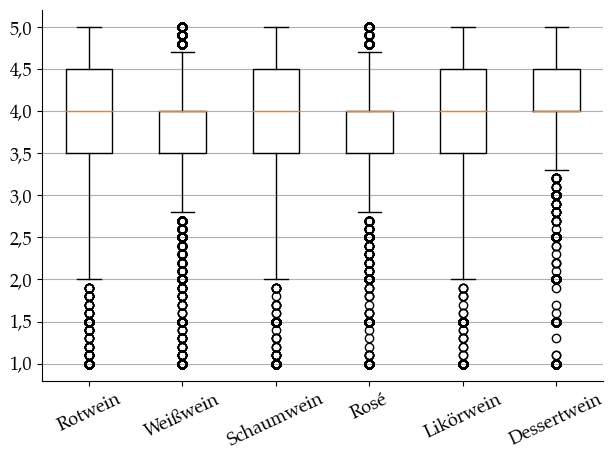

In [142]:
fig, ax = plt.subplots()

for i, type_ in enumerate(df_rev_en['wine_type'].value_counts().index):
    ax.boxplot(
        df_rev_en[df_rev_en['wine_type'] == type_]['rating'],
        positions=[i], widths=0.5, zorder=3
    )
ax.grid(axis='y')
ax.spines[['top', 'right']].set_visible(False)
ax.set_xticklabels(df_rev_en['wine_type'].value_counts().index)
plt.xticks(rotation=25)
fig.tight_layout()
fig.savefig(fig_path + 'reduced_wine_type_box.png', dpi=400)

In [28]:
train = df_en_train[df_en_train['wine_type'] == 'Dessertwein']
test = df_en_test[df_en_test['wine_type'] != 'Dessertwein']

In [29]:
def split(a, n):
    k, m = divmod(len(a), n)
    return list(a[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(n))

evaluation_wines = set()
core_count = 10
df_results = pd.DataFrame()
user_ids = pd.concat([train, test])['user_id'].unique()
user_ids_frames = split(a=user_ids, n=core_count)

with concurrent.futures.ProcessPoolExecutor() as executor:
    results = [
        executor.submit(count_corresponding_reviews.count_corresponding_reviews, [train, test, user_ids_frames[i]]) for
        i in
        range(core_count)]

    for result in concurrent.futures.as_completed(results):
        df_results = pd.concat([df_results, result.result()])
print('Users considered in evaluation: ', len(df_results[df_results['corresponding_reviews_evaluation'] > 0]))
print('corresponding_reviews_evaluation: ', str(df_results['corresponding_reviews_evaluation'].sum()))

Users considered in evaluation:  14732
corresponding_reviews_evaluation:  315055


In [30]:
df_cross_domain = pd.DataFrame(
    {
        'wine_type': ['Rotwein', 'Weißwein', 'Schaumwein', 'Rosé', 'Likörwein', 'Dessertwein'],
        'user': [49338, 50599, 36718, 26110, 16786, 14732],
        'corresponding_reviews': [2067184, 2088232, 1575788, 326158, 412055, 315055]
    }
)

/var/folders/0w/wzymnpfd4rjdkg4k8khhk6dc0000gn/T/ipykernel_13738/3118910398.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['', 'Rotwein', 'Weißwein', 'Schaumwein', 'Rosé', 'Likörwein', 'Dessertwein'], rotation=25)


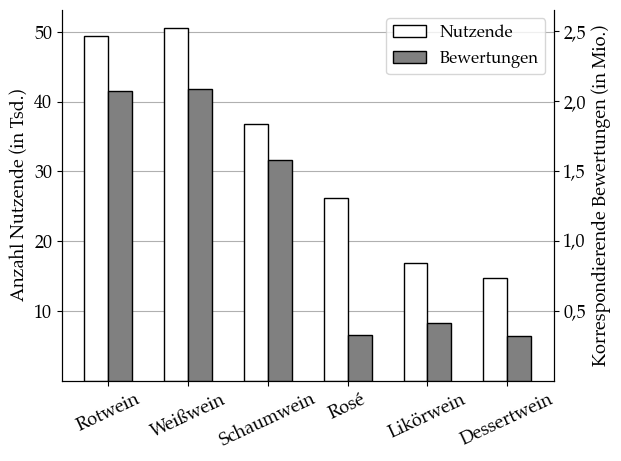

In [115]:
fig, ax = plt.subplots()

width = 0.3
ax2 = ax.twinx()

for i, type_ in enumerate(df_cross_domain['wine_type']):
    ax.bar(
        x=i - 0.15,
        height=df_cross_domain[df_cross_domain['wine_type'] == type_]['user'] / 1000,
        width=width,
        color='white',
        edgecolor='black',
        zorder=3
    )
    ax2.bar(
        x=i + 0.15,
        height=df_cross_domain[df_cross_domain['wine_type'] == type_]['corresponding_reviews'] / 1000000,
        width=width,
        color='grey',
        edgecolor='black',
        zorder=3
    )
ax.set_xticklabels(['', 'Rotwein', 'Weißwein', 'Schaumwein', 'Rosé', 'Likörwein', 'Dessertwein'], rotation=25)
ax.grid(axis='y')
ax2.set_yticks([0.5, 1, 1.5, 2, 2.5])
ax.set_yticks([10, 20, 30, 40, 50])
ax2.set_ylim(0, 2.65)
ax.set_ylabel('Anzahl Nutzende (in Tsd.)')
ax2.set_ylabel('Korrespondierende Bewertungen (in Mio.)')
ax.spines[['top']].set_visible(False)
ax2.spines[['top']].set_visible(False)

ax.legend(handles=[
    Patch(facecolor='white', edgecolor='black', label='Nutzende'),
    Patch(facecolor='grey', edgecolor='black', label='Bewertungen'),
], ncols=1, fontsize=12)

fig.tight_layout()
fig.savefig(fig_path + 'cross_domain_nutzende_bewertungen.pdf')

### Evaluation cross-domain

In [6]:
df_preds = load_from_database(db='predictions', table='nlp_cross_rotwein', columns='*')
df_wine = load_from_database(db='wine_distinct', table='wine_distinct', columns='id, type_id')
df_wine_types = pd.DataFrame({'type_id': wine_type_ids.keys(), 'wine_type': wine_type_ids.values()})
df_wine = df_wine.merge(df_wine_types, on='type_id')
df_preds = df_preds.merge(df_wine, left_on='wine_id', right_on='id', how='left')
df_preds.head()

,index,user_id,wine_id,prediction,rating,id,type_id,wine_type
0,0,41287682,1856143,4.0,4.0,1856143,2,Weißwein
1,1,41287682,1856143,4.4,4.0,1856143,2,Weißwein
2,2,41287682,86686,5.0,4.5,86686,2,Weißwein
3,3,41287682,86686,5.2,4.5,86686,2,Weißwein
4,4,41287682,86686,4.4,4.5,86686,2,Weißwein


In [7]:
df_preds['wine_type'].value_counts()

Weißwein       66029
Schaumwein     31412
Rosé            9109
Likörwein       8292
Dessertwein     5966
Name: wine_type, dtype: int64

In [179]:
df_rev_en_train = load_from_database(db='review_en_train', table='review_en_train', columns='wine_id, note_length')
df_rev_en_test = load_from_database(db='review_en_test', table='review_en_test', columns='wine_id, note_length')
df_wine = load_from_database(db='wine_distinct', table='wine_distinct', columns='id, type_id')
df_wine_types = pd.DataFrame({'type_id': wine_type_ids.keys(), 'wine_type': wine_type_ids.values()})
df_wine = df_wine.merge(df_wine_types, on='type_id')
df_rev_en_train = df_rev_en_train.merge(df_wine, left_on='wine_id', right_on='id', how='left')
df_rev_en_test = df_rev_en_test.merge(df_wine, left_on='wine_id', right_on='id', how='left')
df_rev_en_train.head()

,wine_id,note_length,id,type_id,wine_type
0,6161,19,6161,1,Rotwein
1,1172211,4,1172211,1,Rotwein
2,24210,2,24210,2,Weißwein
3,1703690,72,1703690,3,Schaumwein
4,77472,13,77472,1,Rotwein


In [177]:
df_wine_note_len = pd.DataFrame()
for i, wine_type in enumerate(df_rev_en_train['wine_type'].unique()):
        median_note_length = df_rev_en_train[df_rev_en_train['wine_type'] == wine_type]['note_length'].median()
        df_wine_note_len.loc[i, 'Wein'] = wine_type
        df_wine_note_len.loc[i, 'median_note_length'] = median_note_length
df_wine_note_len

,Wein,median_note_length
0,Rotwein,9.0
1,Weißwein,9.0
2,Schaumwein,9.0
3,Likörwein,10.0
4,Roséwein,8.0
5,Dessertwein,10.0


In [112]:
df_cross_domain_results = pd.DataFrame(
    {
        'Typ': ['NLP', 'NLP', 'NLP', 'NLP', 'NLP', 'NLP', 'Numeric', 'Numeric', 'Numeric', 'Numeric', 'Numeric', 'Numeric'],
        'Wein': ['Rotwein', 'Weißwein', 'Schaumwein', 'Roséwein', 'Likörwein', 'Dessertwein', 'Rotwein', 'Weißwein', 'Schaumwein', 'Roséwein', 'Likörwein', 'Dessertwein'],
        'MSE': [0.6034, 0.5952, 0.6054, 0.6330, 0.6523,  0.6468, 0.5864, 0.5763, 0.5904, 0.6249, 0.6316, 0.6277],
        'RMSE': [0.7787, 0.7715,  0.7781, 0.7956,  0.8076, 0.8043, 0.7658, 0.7592, 0.7684, 0.7905, 0.7947, 0.7923],
        'N': [120808, 125618, 93619, 55762, 43758, 40895, 124943, 129674, 96749, 57331, 45179, 42487]
    }
)
df_cross_domain_results

,Typ,Wein,MSE,RMSE,N
0,NLP,Rotwein,0.6034,0.7787,120808
1,NLP,Weißwein,0.5952,0.7715,125618
2,NLP,Schaumwein,0.6054,0.7781,93619
3,NLP,Roséwein,0.6330,0.7956,55762
4,NLP,Likörwein,0.6523,0.8076,43758
5,NLP,Dessertwein,0.6468,0.8043,40895
6,Numeric,Rotwein,0.5864,0.7658,124943
7,Numeric,Weißwein,0.5763,0.7592,129674
8,Numeric,Schaumwein,0.5904,0.7684,96749
9,Numeric,Roséwein,0.6249,0.7905,57331


/var/folders/0w/wzymnpfd4rjdkg4k8khhk6dc0000gn/T/ipykernel_8656/2774030046.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['', 'Rotwein', 'Weißwein', 'Schaumwein', 'Roséwein', 'Likörwein', 'Dessertwein'], rotation=25)


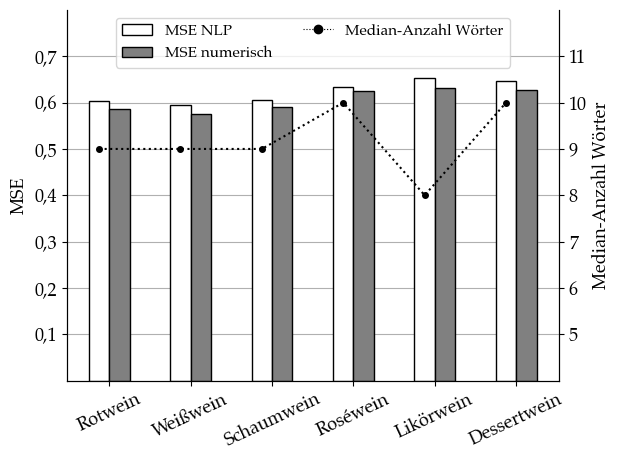

In [175]:
fig, ax = plt.subplots()

ax2 = ax.twinx()

width=0.25
offset = width / 2
x_labels = list(df['Wein'].unique())

for i in range(len(x_labels)):
    ax.bar(
        x= i - offset,
        height=df_cross_domain_results[df_cross_domain_results['Typ'] == 'NLP']['MSE'][i],
        color='white',
        edgecolor='black',
        width=width,
        zorder=3
    )
    ax.bar(
        x= i + offset,
        height=df_cross_domain_results[df_cross_domain_results['Typ'] == 'Numeric']['MSE'][i + 6],
        color='grey',
        edgecolor='black',
        width=width,
        zorder=3
    )

ax2.plot(
    df_wine_note_len.index - offset,
    df_wine_note_len['median_note_length'],
    c='black',
    marker='o',
    linestyle=':',
    markersize=4
)

ax.grid(axis='y')
ax.spines[['top']].set_visible(False)
ax2.spines[['top']].set_visible(False)
ax.set_ylim(0, 0.8)
ax.set_yticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7])
ax2.set_ylim(4, 12)
ax2.set_yticks([5, 6, 7, 8, 9, 10, 11])
ax.set_xticklabels(['', 'Rotwein', 'Weißwein', 'Schaumwein', 'Roséwein', 'Likörwein', 'Dessertwein'], rotation=25)
ax.legend(handles=[
    Patch(facecolor='white', edgecolor='black', label='MSE NLP'),
    Patch(facecolor='grey', edgecolor='black', label='MSE numerisch'),
    Line2D([0], [0], color='black', lw=0.8, linestyle=':', label='Median-Anzahl Wörter', marker='o'),

], ncols=2, fontsize=11, loc='upper center')
ax.set_ylabel('MSE')
ax2.set_ylabel('Median-Anzahl Wörter')
fig.tight_layout()
fig.savefig(fig_path + 'cross_domain_mse_note_len.pdf')

In [191]:
for i in range(len(df_cross_domain_results)):
    n_ = df_cross_domain_results.loc[i, 'N']
    wine_type = df_cross_domain_results.loc[i, 'Wein']
    n_train = df_rev_en_test[df_rev_en_test['wine_type'] != wine_type]['wine_id'].count()
    df_cross_domain_results.loc[i, 'N_share'] = (n_ / n_train) * 100
df_cross_domain_results

,Typ,Wein,MSE,RMSE,N,N_share
0,NLP,Rotwein,0.6034,0.7787,120808,50.037691
1,NLP,Weißwein,0.5952,0.7715,125618,49.703051
2,NLP,Schaumwein,0.6054,0.7781,93619,30.097637
3,NLP,Roséwein,0.6330,0.7956,55762,16.064648
4,NLP,Likörwein,0.6523,0.8076,43758,12.298068
5,NLP,Dessertwein,0.6468,0.8043,40895,11.269069
6,Numeric,Rotwein,0.5864,0.7658,124943,51.750375
7,Numeric,Weißwein,0.5763,0.7592,129674,51.307881
8,Numeric,Schaumwein,0.5904,0.7684,96749,31.103903
9,Numeric,Roséwein,0.6249,0.7905,57331,16.516666


/var/folders/0w/wzymnpfd4rjdkg4k8khhk6dc0000gn/T/ipykernel_8656/1818849735.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['', 'Rotwein', 'Weißwein', 'Schaumwein', 'Roséwein', 'Likörwein', 'Dessertwein'], rotation=25)


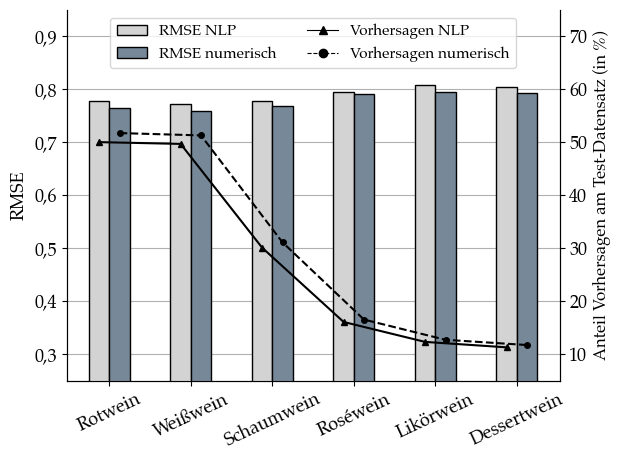

In [218]:
fig, ax = plt.subplots()

ax2 = ax.twinx()

width=0.25
offset = width / 2
x_labels = list(df['Wein'].unique())

for i in range(len(x_labels)):
    ax.bar(
        x= i - offset,
        height=df_cross_domain_results[df_cross_domain_results['Typ'] == 'NLP']['RMSE'][i],
        color='lightgrey',
        edgecolor='black',
        width=width,
        zorder=3
    )
    ax.bar(
        x= i + offset,
        height=df_cross_domain_results[df_cross_domain_results['Typ'] == 'Numeric']['RMSE'][i + 6],
        color='lightslategray',
        edgecolor='black',
        width=width,
        zorder=3
    )
ax2.plot(
    df_cross_domain_results[df_cross_domain_results['Typ'] == 'NLP'].index - offset,
    df_cross_domain_results[df_cross_domain_results['Typ'] == 'NLP']['N_share'] ,
    c='black',
    marker='^',
    markersize=4
)
ax2.plot(
    df_cross_domain_results[df_cross_domain_results['Typ'] == 'NLP'].index + offset,
    df_cross_domain_results[df_cross_domain_results['Typ'] == 'Numeric']['N_share'],
    c='black',
    marker='o',
    markersize=4,
    linestyle='--'
)
ax.grid(axis='y')
ax.spines[['top']].set_visible(False)
ax2.spines[['top']].set_visible(False)
ax.set_ylim(0.25, 0.95)
ax.set_yticks([0.3, 0.4 , 0.5, 0.6, 0.7, 0.8, 0.9])
ax2.set_ylim(5, 75)
ax2.set_yticks([10, 20, 30, 40, 50, 60, 70])
ax.set_xticklabels(['', 'Rotwein', 'Weißwein', 'Schaumwein', 'Roséwein', 'Likörwein', 'Dessertwein'], rotation=25)

ax.legend(handles=[
    Patch(facecolor='lightgrey', edgecolor='black', label='RMSE NLP'),
    Patch(facecolor='lightslategray', edgecolor='black', label='RMSE numerisch'),
    Line2D([0], [0], color='black', lw=0.8, label='Vorhersagen NLP', marker='^'),
    Line2D([0], [0], color='black', linestyle='--', lw=0.8, label='Vorhersagen numerisch', marker='o')


], ncols=2, fontsize=11, loc='upper center')
ax.set_ylabel('RMSE')
ax2.set_ylabel('Anteil Vorhersagen am Test-Datensatz (in %)', fontsize=12)
fig.tight_layout()
fig.savefig(fig_path + 'cross_domain_rmse_preds_count.pdf')

In [182]:
df_rev_en_test['wine_type'].value_counts().values

array([132774, 121471,  63157,  27098,  18396,  11312])

In [174]:
percentages = dict()
for wine_type in set(df_cross_domain_results['Wein']):
    mse_nlp = df_cross_domain_results[
        (df_cross_domain_results['Typ'] == 'NLP') &
        (df_cross_domain_results['Wein'] == wine_type)

    ]['MSE'].values[0]
    mse_numeric = df_cross_domain_results[
        (df_cross_domain_results['Typ'] == 'Numeric') &
        (df_cross_domain_results['Wein'] == wine_type)
    ]['MSE'].values[0]
    percentages[wine_type] =  (1 - (mse_numeric / mse_nlp)) * 100

percentages

{'Schaumwein': 2.4777006937561907,
 'Weißwein': 3.175403225806439,
 'Roséwein': 1.2796208530805653,
 'Dessertwein': 2.952999381570809,
 'Likörwein': 3.1733864786141264,
 'Rotwein': 2.8173682466025918}